In [2]:
spark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
%matplotlib inline
import json
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

In [4]:
spark = SparkSession.builder.appName('TwitterCovid19_EmotionAttributes').getOrCreate()

#change configuration settings on Spark 
#conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.ui.proxyBase', '/proxy/application_1638408497775_0002'),
 ('spark.yarn.historyServer.address', 'bigdatacluster2-m:18080'),
 ('spark.sql.warehouse.dir', 'file:/spark-warehouse'),
 ('spark.yarn.dist.jars',
  'file:///root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-3.3.2.jar,file:///root/.ivy2/jars/com.typesafe_config-1.4.1.jar,file:///root/.ivy2/jars/org.rocksdb_rocksdbjni-6.5.3.jar,file:///root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.603.jar,file:///root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,file:///root/.ivy2/jars/com.navigamez_greex-1.0.jar,file:///root/.ivy2/jars/org.json4s_json4s-ext_2.12-3.5.3.jar,file:///root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.3.3.jar,file:///root/.ivy2/jars/net.sf.trove4j_trove4j-3.0.3.jar,file:///root/.ivy2/jars/com.google.code.findbugs_annotations-3.0.1.jar,file:///root/.ivy2/jars/com.google.protobuf_protobuf

In [5]:
sparknlp.start()

In [6]:
df = spark.read.option("multiline","true") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("ignoreTrailingWhiteSpace","true") \
    .option("ignoreLeadingWhiteSpace", "true") \
    .option("escapechar", "\n") \
    .option('escape','"') \
    .csv("gs://bigdata_project_hksv/tweetData/*.csv")

21/12/02 02:17:12 WARN org.apache.hadoop.util.concurrent.ExecutorHelper: Thread (Thread[GetFileInfo #9,5,main]) interrupted: 
java.lang.InterruptedException
	at com.google.common.util.concurrent.AbstractFuture.get(AbstractFuture.java:510)
	at com.google.common.util.concurrent.FluentFuture$TrustedFuture.get(FluentFuture.java:88)
	at org.apache.hadoop.util.concurrent.ExecutorHelper.logThrowableFromAfterExecute(ExecutorHelper.java:48)
	at org.apache.hadoop.util.concurrent.HadoopThreadPoolExecutor.afterExecute(HadoopThreadPoolExecutor.java:90)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1157)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
21/12/02 02:17:12 WARN org.apache.hadoop.util.concurrent.ExecutorHelper: Thread (Thread[GetFileInfo #8,5,main]) interrupted: 
java.lang.InterruptedException
	at com.google.common.util.concurrent.AbstractFuture.get(AbstractFuture.java:510)
	at c

In [7]:
df1 = df.dropna(thresh=1, subset=('tweet'))
display(df1)

DataFrame[tweet_id: bigint, tdate: string, ttime: string, tlang: string, tcountry_place: string, month_year: string, tweet: string]

In [8]:
df1.show(truncate = False)

+-------------------+----------+--------+-----+--------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet_id           |tdate     |ttime   |tlang|tcountry_place|month_year|tweet                                                                                                                                                                                                                                                                                     |
+-------------------+----------+--------+-----+--------------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
df1 = df1.filter(df1.tlang == "en")
df1.show()

+-------------------+----------+--------+-----+--------------+----------+--------------------+
|           tweet_id|     tdate|   ttime|tlang|tcountry_place|month_year|               tweet|
+-------------------+----------+--------+-----+--------------+----------+--------------------+
|1292160311273947136|2020-08-08|18:06:40|   en|          NULL|   2020-08|Democrats say COV...|
|1292160314889457673|2020-08-08|18:06:40|   en|          NULL|   2020-08|COVID-stricken An...|
|1292160315027849217|2020-08-08|18:06:40|   en|          NULL|   2020-08|Did I happen to m...|
|1292160317867335680|2020-08-08|18:06:41|   en|          NULL|   2020-08|Georgia School Li...|
|1292160318743949313|2020-08-08|18:06:41|   en|          NULL|   2020-08|Brazil now has 10...|
|1292160319171657730|2020-08-08|18:06:41|   en|          NULL|   2020-08|For all the hemmi...|
|1292160320463667200|2020-08-08|18:06:42|   en|          NULL|   2020-08|97,000 children r...|
|1292160320514019330|2020-08-08|18:06:42|   en|   

In [10]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

In [11]:
def preprocessing(lines):
    words = lines.select(explode(split(lines.value, "t_end")).alias("word"))
    words = words.na.replace('', None)
    words = words.na.drop()
    words = words.withColumn('word', F.regexp_replace('word', r'http\S+', ''))
    words = words.withColumn('word', F.regexp_replace('word', '@\w+', ''))
    words = words.withColumn('word', F.regexp_replace('word', '#', ''))
    words = words.withColumn('word', F.regexp_replace('word', 'RT', ''))
    words = words.withColumn('word', F.regexp_replace('word', ':', ''))
    return words

In [12]:
df2 = df1.withColumn('tweet1',regexp_replace(col('tweet'), '@', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet1'), '#', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet2'), 'RT', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet2'), ':', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet2'), 'http\S+', ''))

In [13]:
df2.select(col('tweet2')).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet2                                                                                                                                                                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Democrats say COVID19 is really really really really really really really bad! Then blame the President for everything like a little kid would do on the 

In [14]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

In [15]:
model_name = 'classifierdl_use_emotion'

In [16]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = ClassifierDLModel.pretrained(name=model_name)\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
Download done! Loading the resource.
[ / ]

[ — ]

[ — ]

21/12/02 02:19:35 WARN org.apache.hadoop.hdfs.client.impl.BlockReaderFactory: I/O error constructing remote block reader.
java.net.SocketTimeoutException: 60000 millis timeout while waiting for channel to be ready for read. ch : java.nio.channels.SocketChannel[connected local=/10.128.15.222:35662 remote=/10.128.15.221:9866]
	at org.apache.hadoop.net.SocketIOWithTimeout.doIO(SocketIOWithTimeout.java:164)
	at org.apache.hadoop.net.SocketInputStream.read(SocketInputStream.java:161)
	at org.apache.hadoop.net.SocketInputStream.read(SocketInputStream.java:131)
	at org.apache.hadoop.net.SocketInputStream.read(SocketInputStream.java:118)
	at java.io.FilterInputStream.read(FilterInputStream.java:83)
	at org.apache.hadoop.hdfs.protocolPB.PBHelperClient.vintPrefixed(PBHelperClient.java:549)
	at org.apache.hadoop.hdfs.client.impl.BlockReaderRemote.newBlockReader(BlockReaderRemote.java:407)
	at org.apache.hadoop.hdfs.client.impl.BlockReaderFactory.getRemoteBlockReader(BlockReaderFactory.java:855)
	

[OK!]


KeyboardInterrupt: 

In [15]:
empty_df = spark.createDataFrame([['']]).toDF("text")
pipelineModel = nlpPipeline.fit(empty_df)
df = df2.withColumn('text', col('tweet2'))
result = pipelineModel.transform(df)

In [43]:
result.show()

21/12/01 16:47:55 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1638368004038_0006_01_000010 on host: bigdatacluster2-w-3.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 16:47:55.634]Container killed on request. Exit code is 143
[2021-12-01 16:47:55.634]Container exited with a non-zero exit code 143. 
[2021-12-01 16:47:55.634]Killed by external signal
.
21/12/01 16:47:55 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 10 for reason Container from a bad node: container_1638368004038_0006_01_000010 on host: bigdatacluster2-w-3.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 16:47:55.634]Container killed on request. Exit code is 143
[2021-12-01 16:47:55.634]Container exited with a non-zero exit code 143. 
[2021-12-01 16:47:55.634]Killed by external signal
.
21/12/01 16:47:55 ERROR org.apache.spark.scheduler.c

+-------------------+----------+--------+-----+--------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           tweet_id|     tdate|   ttime|tlang|tcountry_place|month_year|               tweet|              tweet1|              tweet2|                text|            document| sentence_embeddings|           sentiment|
+-------------------+----------+--------+-----+--------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|1387861806589358087|2021-04-29|20:10:14|   en|          NULL|   2021-04|Thank God...let’s...|Thank God...let’s...|Thank God...let’s...|Thank God...let’s...|[{document, 0, 90...|[{sentence_embedd...|[{category, 0, 90...|
|1387861807532896258|2021-04-29|20:10:14|   en|          NULL|   2021-04|👇💥👇💥👇OHH FFS...|👇💥👇💥👇OHH FFS...|  👇💥👇💥👇OHH 

In [20]:
result.select('sentiment.result').show()

+----------+
|    result|
+----------+
|    [fear]|
|    [fear]|
|    [fear]|
|    [fear]|
|     [joy]|
|     [joy]|
|    [fear]|
|    [fear]|
|[surprise]|
|    [fear]|
|    [fear]|
| [sadness]|
|[surprise]|
|[surprise]|
|    [fear]|
|    [fear]|
|    [fear]|
|    [fear]|
|    [fear]|
|     [joy]|
+----------+
only showing top 20 rows



In [16]:
df_res = result.selectExpr("tweet_id","text","tdate","tcountry_place","month_year","explode(sentiment.metadata) sentiments", "sentiment") \
        .selectExpr("tweet_id","text","tdate","tcountry_place","month_year","explode(sentiments)", "sentiment.result result")



In [40]:
df_res.show()

21/12/01 15:51:57 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1638368004038_0005_01_000005 on host: bigdatacluster2-w-2.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 15:51:57.394]Container killed on request. Exit code is 143
[2021-12-01 15:51:57.395]Container exited with a non-zero exit code 143. 
[2021-12-01 15:51:57.395]Killed by external signal
.
21/12/01 15:51:57 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 5 for reason Container from a bad node: container_1638368004038_0005_01_000005 on host: bigdatacluster2-w-2.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 15:51:57.394]Container killed on request. Exit code is 143
[2021-12-01 15:51:57.395]Container exited with a non-zero exit code 143. 
[2021-12-01 15:51:57.395]Killed by external signal
.
21/12/01 15:51:57 ERROR org.apache.spark.scheduler.cl

Py4JJavaError: An error occurred while calling o860.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 21.0 failed 4 times, most recent failure: Lost task 0.3 in stage 21.0 (TID 26) (bigdatacluster2-w-2.us-west1-a.c.even-hull-328204.internal executor 8): ExecutorLostFailure (executor 8 exited caused by one of the running tasks) Reason: Container from a bad node: container_1638368004038_0005_01_000008 on host: bigdatacluster2-w-2.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 15:52:58.007]Container killed on request. Exit code is 143
[2021-12-01 15:52:58.007]Container exited with a non-zero exit code 143. 
[2021-12-01 15:52:58.008]Killed by external signal
.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2259)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2208)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2207)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2446)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2388)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2377)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2204)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2225)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2244)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [17]:
df_res = df_res.drop('key', 'value')

In [1]:
df_res = df_res.distinct()

NameError: name 'df_res' is not defined

In [19]:
df_res_2 = df_res.withColumnRenamed("value", "emotion_score")

In [20]:
df_res_2 = df_res_2.withColumnRenamed("result", "emotion")

In [28]:
df_res_2.show()

+-------------------+--------------------+----------+--------------+----------+---------+
|           tweet_id|                text|     tdate|tcountry_place|month_year|  emotion|
+-------------------+--------------------+----------+--------------+----------+---------+
|1387861939292880900|Tarrant County Sp...|2021-04-29|          NULL|   2021-04|    [joy]|
|1388023549659471875|We need to end le...|2021-04-30|          NULL|   2021-04|   [fear]|
|1388024510184497153|Sp00nerism Game O...|2021-04-30|          NULL|   2021-04|    [joy]|
|1388115803803848707|Who have province...|2021-04-30|          NULL|   2021-04|    [joy]|
|1388137041846628356|IrfanAnsariMLA Da...|2021-04-30|          NULL|   2021-04|   [fear]|
|1388155784144424961|GovSisolak The CO...|2021-04-30|          NULL|   2021-04|   [fear]|
|1388162498671435776|Thai government p...|2021-04-30|          NULL|   2021-04|   [fear]|
|1388170136130134029|Hey Michiganders ...|2021-04-30|          NULL|   2021-04|   [fear]|
|138819105

In [21]:
from pyspark.sql.functions import col, concat_ws
df_res_2 = df_res_2.withColumn("emotion",
   concat_ws(",",col("emotion")))
df_res_2.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- tdate: string (nullable = true)
 |-- tcountry_place: string (nullable = true)
 |-- month_year: string (nullable = true)
 |-- emotion: string (nullable = false)



In [22]:
df_result_joy = df_res_2.filter(df_res_2.emotion == "joy")
df_result_fear = df_res_2.filter(df_res_2.emotion == "fear")
df_result_surprise = df_res_2.filter(df_res_2.emotion == "sadness")
df_result_sadness = df_res_2.filter(df_res_2.emotion == "surprise")

In [70]:
df_result_joy.show()

21/12/01 17:16:43 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1638368004038_0006_01_000021 on host: bigdatacluster2-w-2.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 17:16:44.285]Container killed on request. Exit code is 143
[2021-12-01 17:16:44.285]Container exited with a non-zero exit code 143. 
[2021-12-01 17:16:44.285]Killed by external signal
.
21/12/01 17:16:43 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 21 for reason Container from a bad node: container_1638368004038_0006_01_000021 on host: bigdatacluster2-w-2.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 17:16:44.285]Container killed on request. Exit code is 143
[2021-12-01 17:16:44.285]Container exited with a non-zero exit code 143. 
[2021-12-01 17:16:44.285]Killed by external signal
.
21/12/01 17:16:43 ERROR org.apache.spark.scheduler.c

Py4JJavaError: An error occurred while calling o1246.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 31.0 failed 4 times, most recent failure: Lost task 0.3 in stage 31.0 (TID 47) (bigdatacluster2-w-1.us-west1-a.c.even-hull-328204.internal executor 24): ExecutorLostFailure (executor 24 exited caused by one of the running tasks) Reason: Container from a bad node: container_1638368004038_0006_01_000024 on host: bigdatacluster2-w-1.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 17:17:42.724]Container killed on request. Exit code is 143
[2021-12-01 17:17:42.725]Container exited with a non-zero exit code 143. 
[2021-12-01 17:17:42.725]Killed by external signal
.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2259)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2208)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2207)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2446)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2388)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2377)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)


In [ ]:
#pdf_joy = pd.read_csv

In [23]:
pdf_joy = df_result_joy.toPandas()

In [47]:
pdf_joy = df_result_joy.toPandas()
pdf_fear = df_result_fear.toPandas()
pdf_surprise = df_result_surprise.toPandas()
pdf_sadness = df_result_sadness.toPandas()

21/12/01 15:58:02 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1638368004038_0005_01_000009 on host: bigdatacluster2-w-1.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 15:58:02.500]Container killed on request. Exit code is 143
[2021-12-01 15:58:02.500]Container exited with a non-zero exit code 143. 
[2021-12-01 15:58:02.500]Killed by external signal
.
21/12/01 15:58:02 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 9 for reason Container from a bad node: container_1638368004038_0005_01_000009 on host: bigdatacluster2-w-1.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 15:58:02.500]Container killed on request. Exit code is 143
[2021-12-01 15:58:02.500]Container exited with a non-zero exit code 143. 
[2021-12-01 15:58:02.500]Killed by external signal
.
21/12/01 15:58:02 ERROR org.apache.spark.scheduler.cl

KeyboardInterrupt: 

In [24]:
df_res_2.createOrReplaceTempView("vw_results")

In [ ]:
spark.sql("SELECT * FROM vw_results where tweet_id in ('1387861832124227587', '1387861855486554114', '1387861866635046914','1387861845336338434', '1387861855096344577', '1387861863698878464', '1387861871743668228')").show()




In [ ]:
spark.sql("SELECT * FROM vw_results where tweet_id like '138796197812404%'").show()


In [25]:
pd_emotion_count = spark.sql("SELECT EMOTION, COUNT(*) as TWEET_COUNT FROM vw_results GROUP BY EMOTION")

In [37]:
pd_emotion_count.show()

21/12/01 03:59:49 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1638330131916_0001_01_000008 on host: bigdatacluster2-w-0.us-east1-b.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 03:59:49.063]Container killed on request. Exit code is 143
[2021-12-01 03:59:49.063]Container exited with a non-zero exit code 143. 
[2021-12-01 03:59:49.063]Killed by external signal
.
21/12/01 03:59:49 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 8 for reason Container from a bad node: container_1638330131916_0001_01_000008 on host: bigdatacluster2-w-0.us-east1-b.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 03:59:49.063]Container killed on request. Exit code is 143
[2021-12-01 03:59:49.063]Container exited with a non-zero exit code 143. 
[2021-12-01 03:59:49.063]Killed by external signal
.
21/12/01 03:59:49 ERROR org.apache.spark.scheduler.cl

Py4JJavaError: An error occurred while calling o483.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 20.0 failed 4 times, most recent failure: Lost task 0.3 in stage 20.0 (TID 32) (bigdatacluster2-w-1.us-east1-b.c.even-hull-328204.internal executor 10): ExecutorLostFailure (executor 10 exited caused by one of the running tasks) Reason: Container from a bad node: container_1638330131916_0001_01_000010 on host: bigdatacluster2-w-1.us-east1-b.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 04:00:35.817]Container killed on request. Exit code is 143
[2021-12-01 04:00:35.817]Container exited with a non-zero exit code 143. 
[2021-12-01 04:00:35.817]Killed by external signal
.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2259)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2208)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2207)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2446)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2388)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2377)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)


In [26]:
pd_plot_emotion = pd_emotion_count.toPandas() 
type(pd_plot_emotion) 
pd_plot_emotion.head()

,EMOTION,TWEET_COUNT
0,joy,688
1,fear,1143
2,surprise,211
3,sadness,193


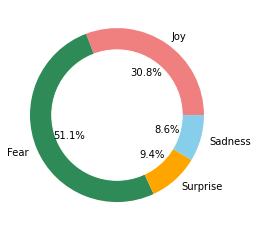

In [38]:
import matplotlib.pyplot as plt
 

names = ['Joy', 'Fear', 'Surprise', 'Sadness']
size = [688,1143,211,193]
 

my_circle = plt.Circle( (0,0), 0.75, color='white')

plt.pie(size, labels=names, colors=['lightcoral','seagreen','orange','skyblue'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)


In [51]:
pd_emotion_over_time = spark.sql("SELECT EMOTION, CAST(CAST(month_year AS STRING) AS DATE) AS MONTH_YEAR, COUNT(*) as TWEET_COUNT FROM vw_results GROUP BY EMOTION, month_year")


In [52]:
pd_emotion_over_time = pd_emotion_over_time.toPandas() 
type(pd_emotion_over_time) 
pd_emotion_over_time.head()

,EMOTION,MONTH_YEAR,TWEET_COUNT
0,surprise,2021-04-01,211
1,fear,2021-04-01,1143
2,sadness,2021-04-01,193
3,joy,2021-04-01,688


<AxesSubplot:xlabel='MONTH_YEAR', ylabel='TWEET_COUNT'>

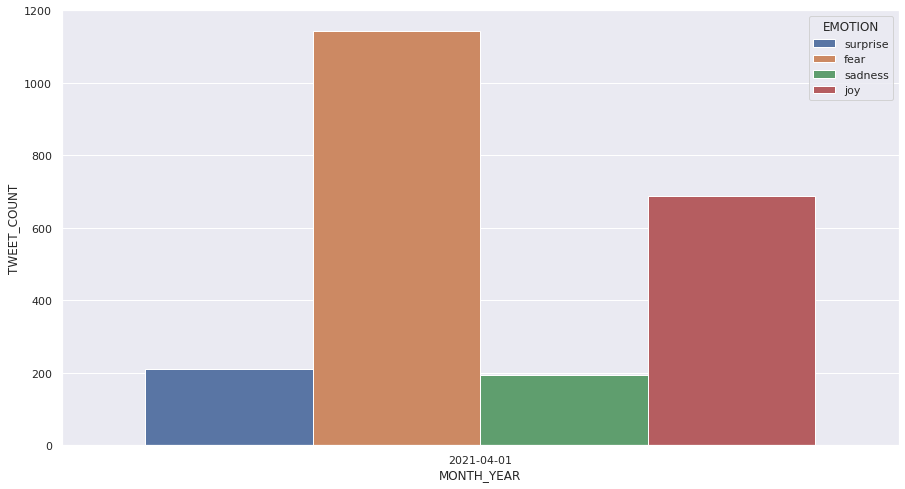

In [54]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)}) 
sns.barplot(data=pd_emotion_over_time, x="MONTH_YEAR", y="TWEET_COUNT", hue = 'EMOTION')

In [68]:
pd_emotion_by_country = spark.sql("SELECT EMOTION, tcountry_place, int(COUNT(*)) as TWEET_COUNT FROM\
(SELECT * FROM vw_results WHERE tcountry_place <> 'NULL') a GROUP BY EMOTION, tcountry_place")

pd_emotion_by_country.show()

21/12/01 17:07:39 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1638368004038_0006_01_000019 on host: bigdatacluster2-w-0.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 17:07:40.315]Container killed on request. Exit code is 143
[2021-12-01 17:07:40.315]Container exited with a non-zero exit code 143. 
[2021-12-01 17:07:40.316]Killed by external signal
.
21/12/01 17:07:39 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 19 for reason Container from a bad node: container_1638368004038_0006_01_000019 on host: bigdatacluster2-w-0.us-west1-a.c.even-hull-328204.internal. Exit status: 143. Diagnostics: [2021-12-01 17:07:40.315]Container killed on request. Exit code is 143
[2021-12-01 17:07:40.315]Container exited with a non-zero exit code 143. 
[2021-12-01 17:07:40.316]Killed by external signal
.
21/12/01 17:07:39 ERROR org.apache.spark.scheduler.c

+--------+--------------+-----------+
| EMOTION|tcountry_place|TWEET_COUNT|
+--------+--------------+-----------+
| sadness|            US|          3|
|    fear|            AU|          1|
|     joy|            IN|          3|
|     joy|            IE|          1|
|     joy|            DE|          1|
| sadness|            GB|          1|
|    fear|            US|          4|
|    fear|            JM|          1|
|    fear|            SG|          1|
|    fear|            CU|          2|
|    fear|            CA|          1|
|    fear|            GB|          1|
|surprise|            IN|          4|
| sadness|            IN|          3|
|surprise|            US|          5|
|     joy|            US|          2|
| sadness|            JM|          1|
|     joy|            GH|          1|
|    fear|            KE|          1|
|    fear|            CO|          1|
+--------+--------------+-----------+
only showing top 20 rows



In [43]:
pd_emotion_by_country = pd_emotion_by_country.toPandas() 
type(pd_emotion_by_country) 
pd_emotion_by_country.head()

NameError: name 'pd_emotion_by_country' is not defined

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,20))
sns.barplot(x= 'TWEET_COUNT', y='tcountry_place', hue='EMOTION', data = pd_emotion_by_country, ax=ax)